In [57]:
import os
import json
import re
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import spacy
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import normalize

In [29]:
nlp = spacy.load("en_core_web_sm")

In [107]:
def read_documents_from_folder(folder_path):
    documents = []
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        if os.path.isfile(file_path):  # Check if it's a file (not a directory)
            with open(file_path, 'r') as file:
                content = file.read()
                documents.append({'filename': filename, 'content': content})
    return documents

In [108]:
def preprocess_documents(documents):
    stop_words = set(stopwords.words('english'))
    ps = PorterStemmer()

    processed_documents = []
    for doc in documents:
        tokens = word_tokenize(doc['content'])
        tokens = [ps.stem(token.lower()) for token in tokens if token.isalnum() and token.lower() not in stop_words]
        processed_content = ' '.join(tokens)
        processed_documents.append({'filename': doc['filename'], 'content': processed_content})

    return processed_documents

def extract_entities(documents):
    extracted_entities = []

    for doc in documents:
        # Process the document with spaCy
        doc_spacy = nlp(doc['content'])
        
        # Extract entities
        for ent in doc_spacy.ents:
            if ent.label_ in ['PERSON', 'GPE', 'ORG']:
                extracted_entities.append((ent.text, ent.label_))
            elif ent.label_ == 'DATE':
                # Extract only the year from date entities
                year_match = re.search(r'(19|20)\d{2}', ent.text)
                if year_match:
                    extracted_entities.append((year_match.group(), 'YEAR'))
            elif ent.label_ == 'PHONE':
                # Extract phone numbers using regex
                phone_numbers = re.findall(r'\(\d{3}\)\s*\d{3}-\d{4}', ent.text)
                for phone_number in phone_numbers:
                    extracted_entities.append((phone_number, 'PHONE_NUMBER'))

    return extracted_entities

In [109]:
def build_document_entity_matrix(documents, extracted_entities):
    # Get unique entity types
    entity_types = set([entity[1] for entity in extracted_entities])

    # Step 3: Create document-entity matrix
    vectorizer = CountVectorizer(vocabulary=entity_types)
    document_contents = [doc['content'] for doc in documents]
    document_entity_matrix = vectorizer.fit_transform(document_contents)

     # Convert sparse matrix to dense array
    dense_matrix = document_entity_matrix.toarray()

    # Step 4: Optional normalization
    # Normalize the document-entity matrix to account for variations in document length or entity frequency
    document_entity_matrix_normalized = normalize(dense_matrix, norm='l2')
    return document_entity_matrix_normalized, entity_types

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import MDS

def apply_mds(document_entity_matrix_normalized):
    # Calculate pairwise cosine similarity between documents
    pairwise_similarity = cosine_similarity(document_entity_matrix_normalized)

    # Convert similarity to dissimilarity (1 - similarity)
    pairwise_dissimilarity = 1 - pairwise_similarity

    # Apply Multidimensional Scaling (MDS)
    mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
    embedded_docs = mds.fit_transform(pairwise_dissimilarity)

    return embedded_docs

In [110]:
def visualize_documents(embedded_docs, clusters, documents):
    plt.figure(figsize=(15, 8))
    for label, filenames in clusters.items():
        x = [embedded_docs[i, 0] for i, doc in enumerate(documents) if doc['filename'] in filenames]
        y = [embedded_docs[i, 1] for i, doc in enumerate(documents) if doc['filename'] in filenames]
        plt.scatter(x, y, label=f'Cluster {label}')
    plt.title('Visualization of Documents in Reduced Dimensional Space')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.legend()
    plt.show()



In [136]:
def perform_content_based_clustering(documents, num_clusters):
    # Tokenization, stop word removal, and stemming
    documents_processed = preprocess_documents(documents)

    # Initialize TfidfVectorizer
    tfidf_vectorizer = TfidfVectorizer()

    # Fit and transform the processed content
    contents = [doc['content'] for doc in documents_processed]
    tfidf_matrix = tfidf_vectorizer.fit_transform(contents)

    # Perform K-means clustering
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(tfidf_matrix)

    # Get cluster labels
    labels = kmeans.labels_

    # Group documents by clusters
    clusters = {}
    document_cluster_map = {}
    for i, label in enumerate(labels):
        if label not in clusters:
            clusters[label] = []
        clusters[label].append(documents_processed[i]['filename'])
        document_cluster_map[documents_processed[i]['filename']] = label  # Map filename to cluster ID
    
    return clusters, document_cluster_map

In [139]:
def main():
    # Folder path containing documents
    folder_path = '/Users/bensamuel/MS Courses/CIS 569-01 (Visual Analytics)/Project3/dataset'

    # Read all files from the folder
    documents = read_documents_from_folder(folder_path)
    
    # Extract entities from documents
    extracted_entities = extract_entities(documents)

    # Build document-entity matrix
    document_entity_matrix, entity_types = build_document_entity_matrix(documents, extracted_entities)
   
    # Apply Multidimensional Scaling (MDS)
    embedded_docs = apply_mds(document_entity_matrix)

    # Perform content-based clustering using NLTK
    num_clusters = 10  # Adjust as needed
    clusters, document_cluster_map = perform_content_based_clustering(documents, 10)
    # Prepare MDS data with cluster IDs for JSON serialization
    
    mds_data = [
        {'id': documents[i]['filename'], 
         'x': float(coord[0]),  # Convert numpy float to Python float
         'y': float(coord[1]),  # Convert numpy float to Python float
         'clusterId': int(document_cluster_map[documents[i]['filename']])  # Convert numpy int to Python int if needed
        } for i, coord in enumerate(embedded_docs)
    ]

    # Save MDS coordinates to a JSON file
    with open('mds.json', 'w') as mds_file:
        json.dump(mds_data, mds_file, indent=4)

    # Visualize documents if needed
    visualize_documents(embedded_docs, clusters, documents)


/Users/bensamuel/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:1381: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(
/Users/bensamuel/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/Users/bensamuel/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


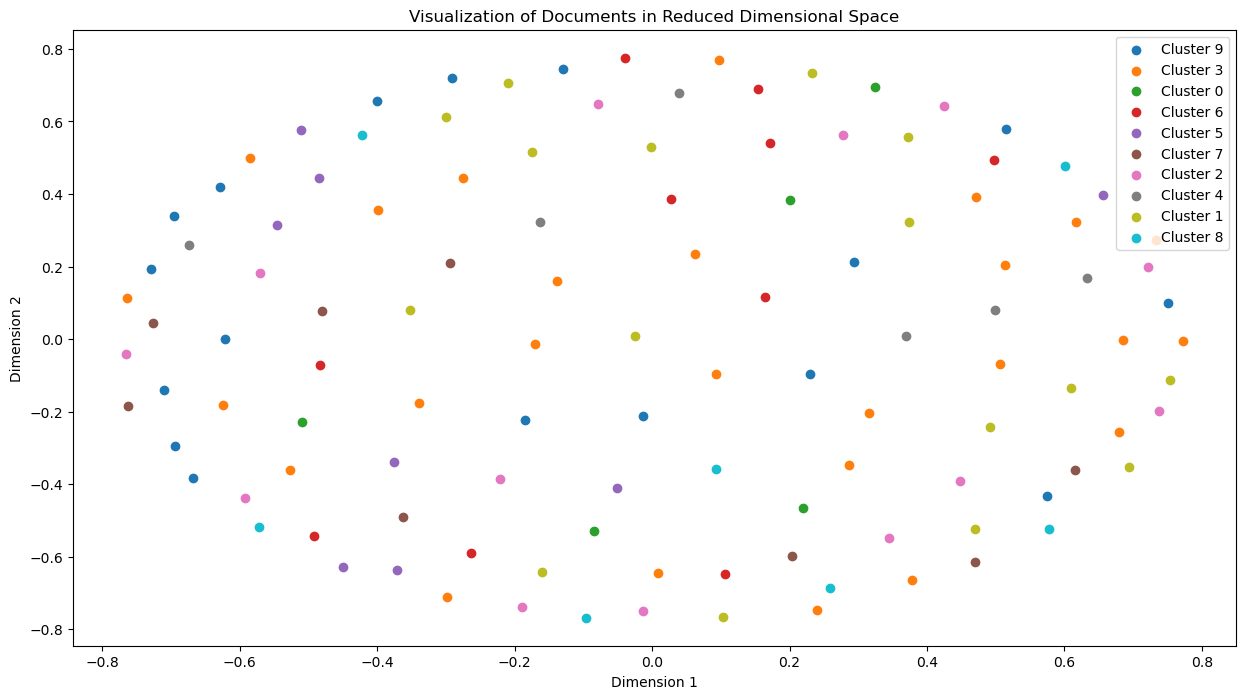

In [140]:
if __name__ == "__main__":
    main()